# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
#def P1(num_examples=5):
### STUDENT START ###
def P1(num_examples=5):
    for i in range(num_examples):
        example = train_data[i]
        label_index = train_labels[i]
        label_name = newsgroups_train.target_names[label_index]

        print '***** BEGIN EXAMPLE ' + str(i) + ' *****'
        print 'Training label: ' + str(label_index) + ' (' + label_name + ')'
        print 'Text:'
        print '-----'

        print ''
        print example
        print ''
        print '***** END EXAMPLE ' + str(i) + ' *****'
        print ''

P1()
### STUDENT END ###
#P1()

***** BEGIN EXAMPLE 0 *****
Training label: 1 (comp.graphics)
Text:
-----

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

***** END EXAMPLE 0 *****

***** BEGIN EXAMPLE 1 *****
Training label: 3 (talk.religion.misc)
Text:
-----



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional 

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [31]:
#def P2():
### STUDENT START ###

def vectorize(data):
    vectorizer = CountVectorizer()
    vectorizer.fit(data)
    return vectorizer

def select_nonzero_indices(example):
    return example.nonzero()[1]

def select_features_by_indices(feature_names, indices):
    features = [
        feature_name
        for index, feature_name
        in enumerate(feature_names)
        if index in indices
    ]
    return features

def select_features_from_example(example, feature_names):
    indices = select_nonzero_indices(example)
    return select_features_by_indices(feature_names, indices)

def select_non_zero_vector(examples):
    (rows, columns) = np.shape(examples)
    nnz_vector = [
        examples[index].nnz
        for index
        in range(rows)
    ]
    
    return nnz_vector

def slice_by_columns(csr_matrix, column_indices):
    csc_matrix = csr_matrix.tocsc()
    csc_sliced = csc_matrix[:, column_indices]
    return csc_sliced.tocsr()

def P2():
    
    def P2a():
        vectorizer = vectorize(train_data)
        train_vectorized = vectorizer.transform(train_data)

        (examples, features) = np.shape(train_vectorized)
        non_zero_total = train_vectorized.nnz
        non_zero_vector = select_non_zero_vector(train_vectorized)
        feature_names = vectorizer.get_feature_names()

        print '***** (2) a. Output of the transform *****'
        print ''
        print '  Size of the vocabulary: ' + str(features)
        print '  Average non-zero features: ' + str(np.mean(non_zero_vector))
        print '  Non-zero fraction: ' + str((non_zero_total * 1.0) / (examples * features * 1.0))
        print ''
        
        return (vectorizer, train_vectorized, feature_names)
    
    (vectorizer, train_vectorized, feature_names) = P2a()
    
    def P2b(vectorizer, train_vectorized, feature_names):
        (examples, features) = np.shape(train_vectorized)
        zeroeth_example = train_vectorized[0]
        last_example = train_vectorized[examples - 1]
        next_to_last_example = train_vectorized[examples - 2]

        zeroeth_features = select_features_from_example(zeroeth_example, feature_names)
        last_features = select_features_from_example(last_example, feature_names)
        next_to_last_features = select_features_from_example(next_to_last_example, feature_names)


        print '***** (2) b. 0th and last feature strings *****'
        print ''
        print '  0th feature string: '
        print '    ' + ' '.join(zeroeth_features)
        print '  last feature string: '
        print '    ' + ' '.join(last_features)
        print '  next to last feature string (last is empty): '
        print '    ' + ' '.join(next_to_last_features)
        print ''
        
    P2b(vectorizer, train_vectorized, feature_names)
    
    def P2c(feature_names):
        four_word_vocabulary = [ 'atheism', 'graphics', 'space', 'religion' ]
        four_word_indices = [
            index
            for index, feature_name
            in enumerate(feature_names)
            if feature_name in four_word_vocabulary
        ]

        four_word_train_vectorized = slice_by_columns(train_vectorized, four_word_indices)
        four_word_non_zero_vector = select_non_zero_vector(four_word_train_vectorized)


        print '***** (2) c. 4 word vocabulary *****'
        print ''

        print '  Shape of four-word vocabulary vectored training data: ' + \
            str(np.shape(four_word_train_vectorized))
        print '  Average non-zero: ' + str(np.mean(four_word_non_zero_vector))
        print ''
    
    P2c(feature_names)
    
    def P2d():
        def vectorize_as_character_bigrams_trigrams(data):
            vectorizer = CountVectorizer(analyzer = 'char_wb', ngram_range = (2, 3))
            vectorizer.fit(data)
            return vectorizer

        vectorizer = vectorize_as_character_bigrams_trigrams(train_data)
        train_char_bigram_trigram_vectorized = vectorizer.transform(train_data)
        (examples, features) = np.shape(train_char_bigram_trigram_vectorized)

        print '***** (2) d. bigram/trigram character features vocabulary *****'
        print ''
        print '  Number of features (word-boundary character bigram/trigram): ' + str(features)
        print ''
    
    P2d()
    
    def P2e():
        def vectorize_with_document_frequency_pruning(data, min_df = 10):
            vectorizer = CountVectorizer(min_df = min_df)
            vectorizer.fit(data)
            return vectorizer

        vectorizer = vectorize_with_document_frequency_pruning(train_data, 10)
        train_vectorized_pruned_min_df_10 = vectorizer.transform(train_data)
        (examples, features) = np.shape(train_vectorized_pruned_min_df_10)

        print '***** (2) e. mininum document frequency 10 vocabulary *****'
        print ''
        print '  Number of features (word-boundary character bigram/trigram): ' + str(features)
        print ''
    
    P2e()
    
    def P2f():
        train_feature_names = vectorize(train_data).get_feature_names()
        dev_feature_names = vectorize(dev_data).get_feature_names()
        feature_names_intersection = set(train_feature_names).intersection(dev_feature_names)

        missing_fraction = 1.0 - ((1.0 * len(feature_names_intersection)) / (1.0 * len(dev_feature_names)))

        print '***** (2) f. fraction of missing dev vocabulary *****'
        print ''
        print '  Fraction of missing dev features from train vocabulary: ' + str(missing_fraction)
        print ''
        
    P2f()
    
    
P2()

### STUDENT END ###
#P2()

***** (2) a. Output of the transform *****

  Size of the vocabulary: 26879
  Average non-zero features: 96.7059980334
  Non-zero fraction: 0.00359782722696

***** (2) b. 0th and last feature strings *****

  0th feature string: 
    3ds able about after all and anyone are available be but carefully cel default does explicitly file for format from given have hi if in information is it know like manual mapping model not nothing noticed only orientation planes position positioned positions preserved prj read reload restarting rule rules rych said save saving somewhere stored texture that the their they this to ve when why with you your
  last feature string: 
    
  next to last feature string (last is empty): 
    _anything_ _behaviors_ _knowledgeable _waving about again all an and any application aquainted around as assertion atheism because becomes becoming being belief believe believer believer_ bit blah by call can carelessly caste certain circular coming contradiction conversely de

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

***** (3) a. k nearest neighbors *****

  Best k: 9
  F1 score over dev data: 0.43656661762

  Mean cosine distance to nearest neighbors: 0.570658164676

***** (3) b. Naive Bayes and Logistic Regression *****
  Naive Bayes best alpha: 0.01 of [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
  Naive Bayes F1 score over dev data: 0.775166321854

  Logistic Regression best C: 0.5 of [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]
  Logistic Regression F1 score over dev data: 0.708473977649

***** (3) b. Naive Bayes and Logistic Regression *****



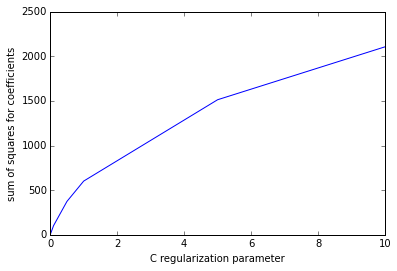

In [26]:
#def P3():
### STUDENT START ###

from sklearn.metrics.pairwise import pairwise_distances

def P3():
    vectorizer = vectorize(train_data)
    train_vectorized = vectorizer.transform(train_data)
    dev_vectorized = vectorizer.transform(dev_data)
    
    def P3a(vectorizer, train_vectorized, dev_vectorized):
        def best_nearest_neighbors(train_vectorized, train_labels, n_neighbors = range(1, 10), verbose = 0):

            hyperparameters = { 'n_neighbors' : n_neighbors } 
            nearest_neighbors = KNeighborsClassifier()

            grid_search = GridSearchCV(nearest_neighbors, hyperparameters, verbose = verbose, scoring = 'f1')
            grid_search.fit(train_vectorized, train_labels)

            return grid_search.best_estimator_

        nearest_neighbors = best_nearest_neighbors(train_vectorized, train_labels)
        
        best_n_neighbors = nearest_neighbors.get_params()['n_neighbors']
        dev_predictions = nearest_neighbors.predict(dev_vectorized)
        knn_f1_score = metrics.f1_score(dev_labels, dev_predictions)

        print '***** (3) a. k nearest neighbors *****'
        print ''
        print '  Best k: ' + str(best_n_neighbors)
        print '  F1 score over dev data: ' + str(knn_f1_score)
        print ''
        
        def cosine_distance(a, b):
            return pairwise_distances(a, b, metric='cosine')[0][0]

        def select_nearest_neighbors(model, examples, example):
            neighbor_indices = model.kneighbors(example)[1][0]
            return examples[neighbor_indices]

        def mean_neighbor_cosine_distance(model, examples):
            (n_examples, features) = np.shape(examples)
            cosine_distances = [ ]

            for example_index in range(n_examples):
                example = examples[example_index]
                neighbors = select_nearest_neighbors(model, examples, example)
                (n_neighbors, features) = np.shape(neighbors)

                example_cosine_distances = [
                    cosine_distance(neighbors[index], example)
                    for index in range(n_neighbors)
                    if index != example_index
                ]

                cosine_distances += example_cosine_distances

            return np.mean(cosine_distances)

        mean_distance = mean_neighbor_cosine_distance(nearest_neighbors, train_vectorized)
        print '  Mean cosine distance to nearest neighbors: ' + str(mean_distance)
        print ''
        
    P3a(vectorizer, train_vectorized, dev_vectorized)

    def P3b(vectorizer, train_vectorized, dev_vectorized):
        def best_naive_bayes(train_data, train_labels, hyperparameters, verbose = 0):
            naive_bayes = MultinomialNB()
            grid_search = GridSearchCV(naive_bayes, hyperparameters, verbose = verbose, scoring = 'f1')
            grid_search.fit(train_data, train_labels)

            return grid_search.best_estimator_

        naive_bayes_hyperparameters = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]}

        naive_bayes = best_naive_bayes(
            train_vectorized, train_labels, naive_bayes_hyperparameters
        )

        best_naive_bayes_alpha = naive_bayes.get_params()['alpha']
        dev_predictions = naive_bayes.predict(dev_vectorized)
        naive_bayes_f1_score = metrics.f1_score(dev_labels, dev_predictions)

        def best_logistic_regression(train_data, train_labels, hyperparameters, verbose = 0):
            logistic_regression = LogisticRegression()
            grid_search = GridSearchCV(logistic_regression, hyperparameters, verbose = verbose, scoring = 'f1')

            grid_search.fit(train_data, train_labels)

            return grid_search.best_estimator_

        logistic_regression_hyperparameters = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]}

        logistic_regression = best_logistic_regression(
            train_vectorized, train_labels, logistic_regression_hyperparameters
        )
        best_logistic_regression_C = logistic_regression.get_params()['C']

        dev_predictions = logistic_regression.predict(dev_vectorized)
        logistic_regression_f1_score = metrics.f1_score(dev_labels, dev_predictions)

        print '***** (3) b. Naive Bayes and Logistic Regression *****'
        print '  Naive Bayes best alpha: ' + str(best_naive_bayes_alpha) + \
          ' of ' + str(naive_bayes_hyperparameters['alpha'])
        print '  Naive Bayes F1 score over dev data: ' + str(naive_bayes_f1_score)
        print ''
        print '  Logistic Regression best C: ' + str(best_logistic_regression_C) + \
          ' of ' + str(logistic_regression_hyperparameters['C'])
        print '  Logistic Regression F1 score over dev data: ' + str(logistic_regression_f1_score)
        print ''
        
    P3b(vectorizer, train_vectorized, dev_vectorized)
    
    def P3c(vectorizer, train_vectorized, dev_vectorized):
        logistic_regression_hyperparameters = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
        logistic_regression_Cs = logistic_regression_hyperparameters['C']

        def get_logistic_regression_coefs(train_data, train_labels, C):
            logistic_regression = LogisticRegression(C = C)
            logistic_regression.fit(train_data, train_labels)
            return logistic_regression.coef_

        sum_of_coef_squares = [
            np.sum(get_logistic_regression_coefs(train_vectorized, train_labels, C) ** 2)
            for C in logistic_regression_Cs
        ]

        print '***** (3) b. Naive Bayes and Logistic Regression *****'
        print ''
        plt.plot(logistic_regression_Cs, sum_of_coef_squares)
        plt.xlabel('C regularization parameter')
        plt.ylabel('sum of squares for coefficients')
        _ = plt.show()
        
    P3c(vectorizer, train_vectorized, dev_vectorized)
P3()

### STUDENT END ###
#P3()

ANSWER:

a. Nearest neighbors works badly because the feature space is very badly covered (10x less examples than features), and even the "nearest" examples are very dissimilar to the inputs (mean cosine distance ~0.50)

b. Standard Logistic Regression is known to suffer from sparse-data bias, for which typical solutions are dimensionality reduction (such as hashing in this case) or using Naive Bayes which shows less sparse data bias. This under-performance is very consistent with the literature.

c. C (the regularization parameter) penalizes large weights so the monotonic relationship of the weight sum of squares to the C value in the graph follows the influence C has on the weight distribution.


(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [39]:
#def P4():
### STUDENT START ###
import pandas as pd

def P4():
    vectorizer = vectorize(train_data)
    train_vectorized = vectorizer.transform(train_data)
    
    logistic_regression = LogisticRegression(C = 0.5)
    logistic_regression.fit(train_vectorized, train_labels)
    
    feature_names = vectorizer.get_feature_names()
    
    def select_top_n_by_weight_indices(coefs, N):
        return np.array(coefs).argsort()[(-N):]
    
    print '***** (4) selecting logistic features *****'
    
    def show_top_features_by_category(vectorizer, logistic_regression, N = 5):
        feature_names = vectorizer.get_feature_names()
        print ''
        print '  Top 5 features by category:'
        print ''
        
        for index, category in enumerate(newsgroups_train.target_names):
            coefs = logistic_regression.coef_[index]
            top_n_indices = select_top_n_by_weight_indices(coefs, N)

            features = select_features_by_indices(feature_names, top_n_indices)

            print '   Category ' + category + ': ' + str(features)

        print ''
    
    show_top_features_by_category(vectorizer, logistic_regression)
    
    def top_features_and_weights(vectorizer, train_vectorized, logistic_regression, N = 5):
        feature_names = vectorizer.get_feature_names()
        
        top_feature_indices_by_category = [
            select_top_n_by_weight_indices(logistic_regression.coef_[category_index], N)
            for category_index 
            in range(len(newsgroups_train.target_names))   
        ]
        
        top_feature_indices = np.unique(np.sort(np.reshape(top_feature_indices_by_category, -1)))
        top_feature_names = select_features_by_indices(feature_names, top_feature_indices)
        
        weights_by_category = {
            category : logistic_regression.coef_[index][top_feature_indices]
            for index, category 
            in enumerate(newsgroups_train.target_names)
        }
        
        data_frame = pd.DataFrame(weights_by_category)
        data_frame.index = top_feature_names
        
        return data_frame
    
    print '  Top 20 features by category (unigrams):'
    print ''
    print(top_features_and_weights(
            vectorizer, train_vectorized, logistic_regression
        ))
    print ''
    
    def vectorize_with_word_bigrams(data):
        vectorizer = CountVectorizer(ngram_range = (2, 2))
        vectorizer.fit(data)
        return vectorizer
    
    bigram_vectorizer = vectorize_with_word_bigrams(train_data)
    train_bigram_vectorized = bigram_vectorizer.transform(train_data)
    bigram_logistic_regression = LogisticRegression(C = 0.5)
    bigram_logistic_regression.fit(train_bigram_vectorized, train_labels)
    
    print '  Top 20 features by category (bigrams):'
    print ''
    print(top_features_and_weights(
            bigram_vectorizer, train_bigram_vectorized, bigram_logistic_regression
        ))
    print ''
P4()

### STUDENT END ###
#P4()

***** (4) selecting logistic features *****

  Top 5 features by category:

   Category alt.atheism: [u'atheism', u'atheists', u'bobby', u'deletion', u'religion']
   Category comp.graphics: [u'3d', u'computer', u'file', u'graphics', u'image']
   Category sci.space: [u'launch', u'nasa', u'orbit', u'space', u'spacecraft']
   Category talk.religion.misc: [u'blood', u'christian', u'christians', u'fbi', u'order']

  Top 20 features by category (unigrams):

            alt.atheism  comp.graphics  sci.space  talk.religion.misc
3d            -0.303420       0.941862  -0.571115           -0.317585
atheism        0.794833      -0.351204  -0.367056           -0.377134
atheists       0.834500      -0.093333  -0.266974           -0.637608
blood         -0.428838      -0.096932  -0.230684            0.847014
bobby          0.823577      -0.191297  -0.286486           -0.387305
christian     -0.482941      -0.339080  -0.247553            0.925647
christians    -0.607427      -0.315386  -0.404441     

ANSWER:

Surprising keywords for unigrams: 
- *deletion* (and to a lesser extent, *computer*) as indicators for *alt.atheism*
- *fbi* and *bloog* as indicators for *talk.religion.misc*

***The Surprise*** for bigrams:
- *cheers kent* as an indicator for both *alt.atheism* and *talk.religion.misc* (likely Kent is a strong contributor to both newsgroups in the message samples)


(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [43]:
#def empty_preprocessor(s):
#    return s

#def better_preprocessor(s):
### STUDENT START ###
def empty_preprocessor(s):
    return s

def vectorize_with_preprocessor(data, preprocessor = empty_preprocessor):
    vectorizer = CountVectorizer(preprocessor = preprocessor)
    vectorizer.fit(data)
    return vectorizer

def f_score_with_preprocessor(train_data, train_labels, dev_data, dev_labels, 
                              preprocessor = empty_preprocessor):
    
    
    vectorizer = vectorize_with_preprocessor(train_data, preprocessor)
    train_vectorized = vectorizer.transform(train_data)
    
    logistic_regression = LogisticRegression(C = 0.5)
    logistic_regression.fit(train_vectorized, train_labels)
    
    dev_vectorized = vectorizer.transform(dev_data)
    dev_predictions = logistic_regression.predict(dev_vectorized)
    
    f_score = metrics.f1_score(dev_labels, dev_predictions)
    
    return f_score

def P5():
    print '***** (5) feature pre-processing *****'
    print ''
    
    baseline_f_score = f_score_with_preprocessor(
        train_data, train_labels, dev_data, dev_labels,
        empty_preprocessor)
    
    print '  Baseline f_score (identity preprocessor): ' + str(baseline_f_score)
    print ''
    
    def preprocessor_v2(s):
        s = s.lower() # lowercase the string
        s = re.sub(r"[^a-z0-9]+", " ", s) # replace all non-alphanumeric characters with a single space
        s = re.sub(r"[\s]+", " ", s) # replace all white space with single space
        s = re.sub(r" [a-z0-9]{1,3} ", " ", s) # throw out the short words between 1 and 3 characters
        s = re.sub(r"[0-9]+", "N", s) # replace all numbers with N
        s = re.sub(r"[aeo]", "", s) # discard all a, e, and o (i's turn out to be important)

        return s
    
    improved_f_score = f_score_with_preprocessor(
        train_data, train_labels, dev_data, dev_labels,
        preprocessor_v2)
    
    print '  Improved f_score (preprocessor v2): ' + str(improved_f_score)
    print ''
    
    baseline_feature_count = len(
        vectorize_with_preprocessor(train_data, empty_preprocessor)
        .get_feature_names())

    print '  Baseline feature count (identity preprocessor): ' + str(baseline_feature_count)
    print ''
    
    improved_feature_count = len(
        vectorize_with_preprocessor(train_data, preprocessor_v2)
        .get_feature_names())
    
    print '  Improved feature count (preprocessor v2): ' + str(improved_feature_count)
    print ''
P5()

### STUDENT END ###

#def P5():
### STUDENT START ###

### STUDENT END ###
#P5()

***** (5) feature pre-processing *****

  Baseline f_score (identity preprocessor): 0.706910918549

  Improved f_score (preprocessor v2): 0.722153661284

  Baseline feature count (identity preprocessor): 33291

  Improved feature count (preprocessor v2): 20423



(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

***** (6) regularization, l1 and l2 penalties *****

  Baseline (L2, C = 0.5, tol = 0.0001) f-score: 0.708473977649
  Baseline (L2, C = 0.5, tol = 0.0001) vocabulary: 26879

  L1 (L1, C = 0.5, tol = 0.0001) f-score: 0.689926975019
  L1 (L1, C = 0.5, tol = 0.0001) vocabulary: 702

  L2 with L1-pruned features 
    (L1, C = 0.0001, tol=0.01 then 
     L2, C = 0.5, tol = 0.0001) f-score: 0.133900253593
  L2 with L1-pruned features 
    (L1, C = 0.0001, tol=0.01 then 
     L2, C = 0.5, tol = 0.0001) vocabulary: 0

  L2 with L1-pruned features 
    (L1, C = 0.001, tol=0.01 then 
     L2, C = 0.5, tol = 0.0001) f-score: 0.334427866295
  L2 with L1-pruned features 
    (L1, C = 0.001, tol=0.01 then 
     L2, C = 0.5, tol = 0.0001) vocabulary: 3

  L2 with L1-pruned features 
    (L1, C = 0.01, tol=0.01 then 
     L2, C = 0.5, tol = 0.0001) f-score: 0.462373935748
  L2 with L1-pruned features 
    (L1, C = 0.01, tol=0.01 then 
     L2, C = 0.5, tol = 0.0001) vocabulary: 16

  L2 with L1-pruned

//anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


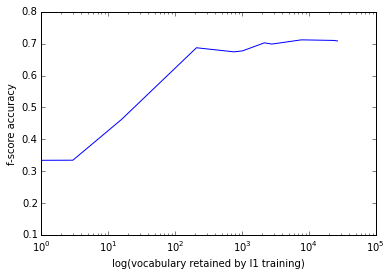

In [44]:
#def P6():
    # Keep this random seed here to make comparison easier.
    #np.random.seed(0)

    ### STUDENT START ###
def P6():
    # Given a logistic regression model, returns indices for features with any non-zero weight
    def select_nonzero_feature_indices(logistic_regression):
        coefs = logistic_regression.coef_
        (categories, examples) = np.shape(coefs)

        nonzero = []
        for category_index in range(categories):
            nonzero_for_category = np.nonzero(coefs[category_index])[0]
            nonzero.extend(nonzero_for_category)

        return np.sort(np.unique(nonzero))

    # Given training and dev data and labels, 
    #   optional column indices for pruning the feature space
    #   and parameters
    # Returns the f_score and non-zero feature indices of the resulting model
    
    # Optionally a set of column indices to slice the feature set by can be passed in
    def f_score_and_nonzero_feature_indices(
        train_data, train_labels, dev_data, dev_labels, vectorizer,
        column_slice_indices = None,
        C = 0.5, penalty = 'l2', tol = 0.001):

        train_vectorized_full = vectorizer.transform(train_data)
        if column_slice_indices is None:
            train_vectorized = train_vectorized_full
        else:
            train_vectorized = slice_by_columns(train_vectorized_full, column_slice_indices)

        logistic_regression = LogisticRegression(C = C, penalty = penalty, tol = tol)
        logistic_regression.fit(train_vectorized, train_labels)

        dev_vectorized_full = vectorizer.transform(dev_data)
        if column_slice_indices is None:
            dev_vectorized = dev_vectorized_full
        else:
            dev_vectorized = slice_by_columns(dev_vectorized_full, column_slice_indices)

        dev_predictions = logistic_regression.predict(dev_vectorized)

        f_score = metrics.f1_score(dev_labels, dev_predictions)
        nonzero_feature_indices = select_nonzero_feature_indices(logistic_regression)

        return (f_score, nonzero_feature_indices)
    
    vectorizer = vectorize(train_data)

    (l2_baseline_f_score, l2_baseline_nonzero_feature_indices) = \
        f_score_and_nonzero_feature_indices(
            train_data, train_labels, dev_data, dev_labels, vectorizer,
            C = 0.5, penalty = 'l2', tol = 0.0001
        )

    print '***** (6) regularization, l1 and l2 penalties *****'
    print ''
    print '  Baseline (L2, C = 0.5, tol = 0.0001) f-score: ' + str(l2_baseline_f_score)
    print '  Baseline (L2, C = 0.5, tol = 0.0001) vocabulary: ' + str(len(l2_baseline_nonzero_feature_indices))

    (l1_C0_5_f_score, l1_C0_5_nonzero_feature_indices) = \
        f_score_and_nonzero_feature_indices(
            train_data, train_labels, dev_data, dev_labels, vectorizer,
            C = 0.5, penalty = 'l1', tol = 0.0001
        )

    print ''
    print '  L1 (L1, C = 0.5, tol = 0.0001) f-score: ' + str(l1_C0_5_f_score)
    print '  L1 (L1, C = 0.5, tol = 0.0001) vocabulary: ' + str(len(l1_C0_5_nonzero_feature_indices))

    logistic_regression_hyperparameters = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0, 1000.0, 10000.0]}

    Cs = logistic_regression_hyperparameters['C']
    f_scores = [ ]
    vocabularies = [ ]
    
    for l1_C in Cs:
        (l1_f_score, l1_nonzero_feature_indices) = \
            f_score_and_nonzero_feature_indices(
                train_data, train_labels, dev_data, dev_labels, vectorizer,
                C = l1_C, penalty = 'l1', tol = 0.01
            )

        (l2_l1_pruned_f_score, l2_l1_pruned_feature_indices) = \
            f_score_and_nonzero_feature_indices(
                train_data, train_labels, dev_data, dev_labels, vectorizer,
                column_slice_indices = l1_nonzero_feature_indices, # use indices from l1 training
                C = 0.5, penalty = 'l2', tol = 0.0001
            )

        print ''
        print '  L2 with L1-pruned features '
        print '    (L1, C = ' + str(l1_C) + ', tol=0.01 then '
        print '     L2, C = 0.5, tol = 0.0001) f-score: ' + str(l2_l1_pruned_f_score)
        print '  L2 with L1-pruned features '
        print '    (L1, C = ' + str(l1_C) + ', tol=0.01 then '
        print '     L2, C = 0.5, tol = 0.0001) vocabulary: ' + str(len(l2_l1_pruned_feature_indices))

        f_scores.append(l2_l1_pruned_f_score)
        vocabularies.append(len(l2_l1_pruned_feature_indices))

    plt.plot(vocabularies, f_scores)
    plt.xscale('log')
    plt.xlabel('log(vocabulary retained by l1 training)')
    plt.ylabel('f-score accuracy')
    _ = plt.show()
P6()
    ### STUDENT END ###
#P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [16]:
#def P7():
### STUDENT START ###

## STUDENT END ###
#P7()

ANSWER:

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.